In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()

In [2]:
base_dir = '/Users/das/work/svn/Gits/a_Projects/101_clembench/clembench-runs'

modprop_df = pd.read_csv(base_dir + '/Addenda/ModelAnalysis2024/Results/model_characteristics.csv')
modprop_df['Release Date'] = pd.to_datetime(modprop_df['Release Date'])
modprop_df['Cut-off Date'] = pd.to_datetime(modprop_df['Cut-off Date'])

## well fuck me. Turns out that the model names can contain trailing whitespaces...
modprop_df['Model Name'] = modprop_df['Model Name'].str.strip()


v16 = pd.read_csv(base_dir + '/v1.6/results.csv')
#v16.loc[:,'model'] = v16.iloc[:,0].str.replace(r'(\w*)-(?:hf-)?t0.0.*', r'\1').str.lower()
v16.loc[:,'model'] = v16.iloc[:,0].str.replace(r'(\w*)-t0.0.*', r'\1').str.lower()


## f me part II: turns out that the results.csv has openchat_3.5, and modprop has openchat-3.5
##  normalise to the latter
v16.loc[v16.model == 'openchat_3.5', 'model'] = 'openchat-3.5'

merged = pd.merge(left=modprop_df, right=v16, left_on='Model Name', right_on='model')

(
 merged.model,
 set(v16.model) - set(merged.model)
)

/var/folders/v4/sxby0fb08xjbdx001s6j3wrh0000gq/T/ipykernel_62218/515090632.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  v16.loc[:,'model'] = v16.iloc[:,0].str.replace(r'(\w*)-t0.0.*', r'\1').str.lower()


(0                        yi-34b-chat
 1                     yi-1.5-6b-chat
 2                     yi-1.5-9b-chat
 3                    yi-1.5-34b-chat
 4                     tulu-2-dpo-70b
 5                         claude-2.1
 6            claude-3-haiku-20240307
 7           claude-3-sonnet-20240229
 8             claude-3-opus-20240229
 9           dolphin-2.5-mixtral-8x7b
 10                         command-r
 11                    command-r-plus
 12                   gemma-1.1-7b-it
 13                       gemma-7b-it
 14           gemini-1.5-flash-latest
 15             gemini-1.5-pro-latest
 16                    gemini-1.0-pro
 17                   codegemma-7b-it
 18                   gemma-1.1-2b-it
 19       meta-llama-3-8b-instruct-hf
 20      meta-llama-3-70b-instruct-hf
 21               llama-2-70b-chat-hf
 22         codellama-34b-instruct-hf
 23          mistral-7b-instruct-v0.1
 24        mixtral-8x7b-instruct-v0.1
 25       mixtral-8x22b-instruct-v0.1
 26         

In [3]:
merged.dropna(subset=['Parameter Size (in billions)'])['Parameter Size (in billions)']

0       34.0
1        6.0
2        9.0
3       34.0
4       70.0
5      137.0
8     2000.0
9       45.0
10      35.0
11     104.0
12       7.0
13       7.0
15    1500.0
17       7.0
18       2.0
19       8.0
20      70.0
21      70.0
22      34.0
23       7.0
24      45.0
25     141.0
28       7.0
29       7.0
30      45.0
31     175.0
32    1760.0
33    1760.0
34    1760.0
35    1760.0
36    1760.0
37       7.0
38       7.0
39       7.0
40       0.5
41       1.8
42       7.0
43      14.0
44      32.0
45      72.0
46      70.0
47      70.0
Name: Parameter Size (in billions), dtype: float64

useful buckets:
- < 6
- (6, 10]
- (10, 60]
- (60, 100]
- (100, 200]
- \> 1000

In [4]:
bin_edges = [0, 6, 10, 60, 100, 200, 1000, 2000]
bin_labels = ['tiny', 'v-small', 'small', 'medium', 'large', 'xxlarge', 'xxxlarge']


merged.loc[:, 'size_bin'] = \
       pd.cut(merged.dropna(subset=['Parameter Size (in billions)'])['Parameter Size (in billions)'], 
       bin_edges, labels=bin_labels)

In [5]:
list(zip(bin_labels, (zip(bin_edges[::], bin_edges[1::]))))

[('tiny', (0, 6)),
 ('v-small', (6, 10)),
 ('small', (10, 60)),
 ('medium', (60, 100)),
 ('large', (100, 200)),
 ('xxlarge', (200, 1000)),
 ('xxxlarge', (1000, 2000))]

In [6]:
merged[['-, clemscore', 'Parameter Size (in billions)', 'size_bin']]

,"-, clemscore",Parameter Size (in billions),size_bin
0,8.27,34.0,small
1,6.73,6.0,tiny
2,4.37,9.0,v-small
3,7.67,34.0,small
4,12.62,70.0,medium
5,32.50,137.0,large
6,22.49,NaN,NaN
7,30.53,NaN,NaN
8,42.42,2000.0,xxxlarge
9,15.10,45.0,small


In [7]:
def plot_tick(x, y, label, width=1, spacing=0.1, fontsize=12, offset=0.1):
    plt.plot([x,x+width], [y,y])
    plt.text(x + width + spacing, y-offset, label, fontsize=fontsize)

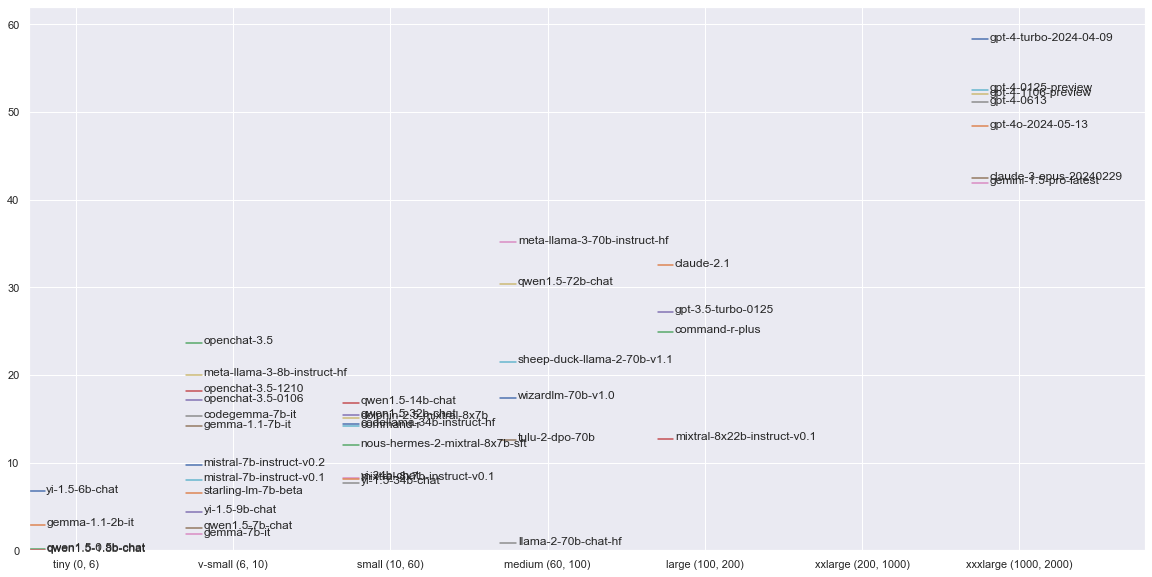

In [8]:
fig, ax = plt.subplots()

col_width = 10

for col_count, this_bin in enumerate(bin_labels):
    for index, model_row in merged[merged.size_bin == this_bin].iterrows():
        #print(model_row['-, clemscore'])
        plot_tick(col_count * col_width, model_row['-, clemscore'], model_row['model'])
    

ax.set_ylim((0,62))
ax.set_xlim((0,71))

ax.set_xticks(range(int(0 + col_width/3), len(bin_labels)*col_width, col_width),
              [a + ' ' + str(b) for a,b in zip(bin_labels, (zip(bin_edges[::], bin_edges[1::])))])
              # bin_labels)    

fig.set_size_inches(20, 10)

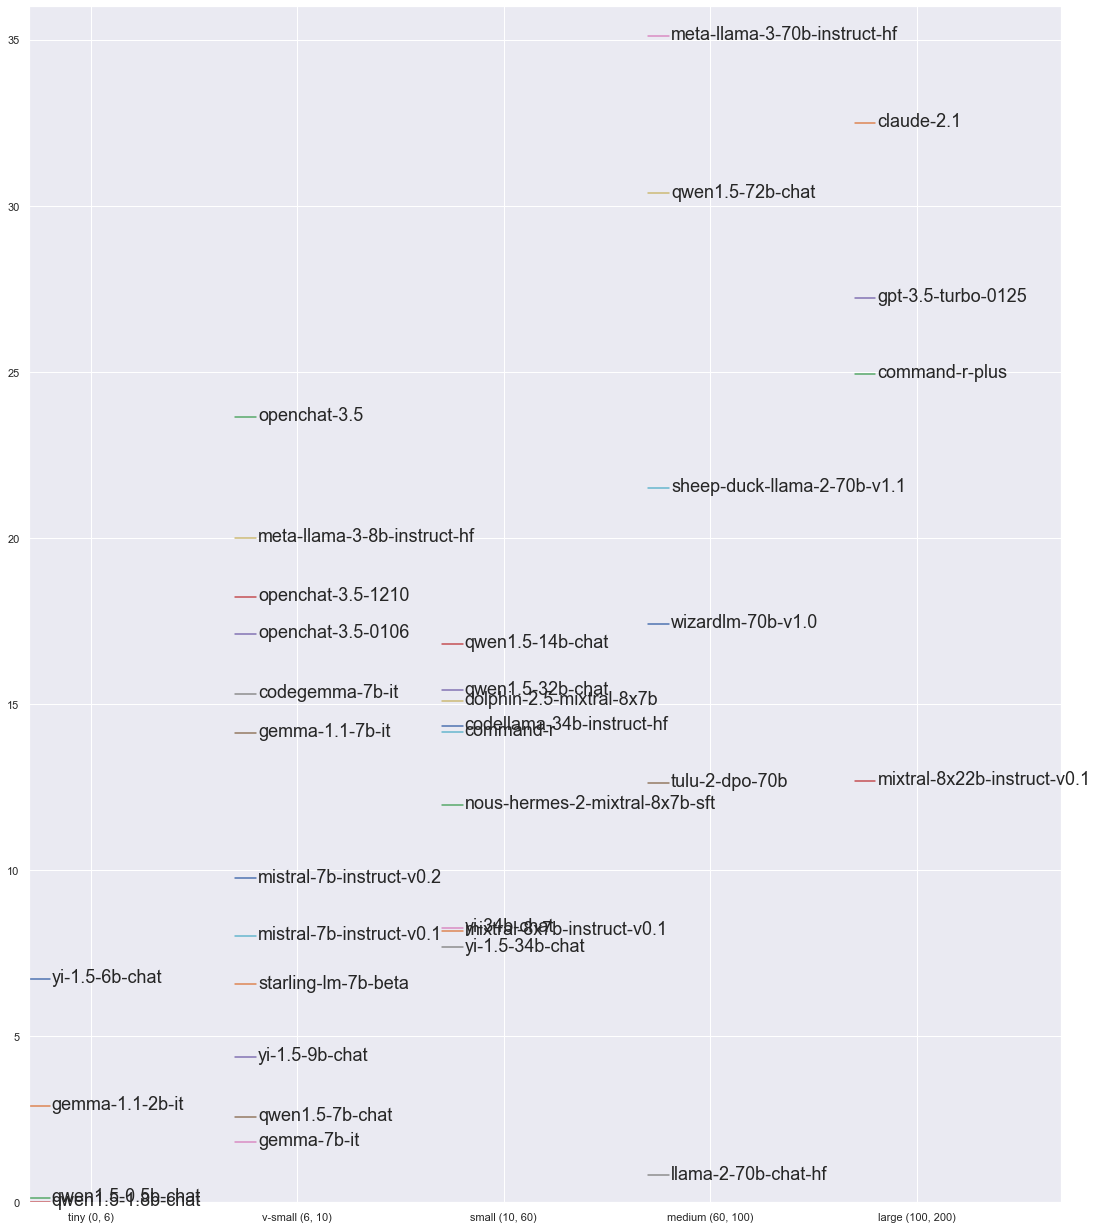

In [9]:
bin_labels = ['tiny', 'v-small', 'small', 'medium', 'large', 'xxlarge', 'xxxlarge']

fig, ax = plt.subplots()

col_width = 10

bin_labels = bin_labels[:-2]

for col_count, this_bin in enumerate(bin_labels):
    for index, model_row in merged[merged.size_bin == this_bin].iterrows():
        #print(model_row['-, clemscore'])
        plot_tick(col_count * col_width, model_row['-, clemscore'], model_row['model'], fontsize=18)
    

ax.set_ylim((0,36))
ax.set_xlim((0,50))

ax.set_xticks(range(int(0 + col_width/3), len(bin_labels)*col_width, col_width),
              [a + ' ' + str(b) for a,b in zip(bin_labels, (zip(bin_edges[::], bin_edges[1::])))])
              # bin_labels)    

fig.set_size_inches(18.5, 22)
plt.savefig('Out/size_buckets_w_model_names.png', bbox_inches='tight')